# Linkres cleanup and filtering

### Boilerplate

In [1]:
%load_ext nb_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/bistable_bundle/r4/hinges
dig80


<IPython.core.display.Javascript object>

### Generate state X and state Y with and without disulfides by doing `KeepSequenceSymmetry` and fixbb design
I will use the serialization build of PyRosetta to enable recording user defined info about the designs.  
This enables downstream inline filtering and data analysis, as well as clustering by lineage.

Record rich information about residues that might be interesting to show/direct switching, GLY, HIS and TRP.  
Record info about sequences and save pdbs for X and Y, with and without disulfide staples  

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose


def almost_linkres(packed_pose_in=None, **kwargs) -> PackedPose:
    """
    Load pose. Design with linkres x3: state_X_nocys, state_Y_nocys,
    state_XY_nocys. Dump X and Y poses with and without disulfides (4 total).
    Return XY without the disulfides.
    """
    import os
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed import cluster
    from pyrosetta.rosetta.core.pack.task.operation import (
        IncludeCurrent,
        InitializeFromCommandline,
        ExtraRotamersGeneric,
    )
    from pyrosetta.rosetta.protocols.denovo_design.movers import FastDesign
    from pyrosetta.rosetta.protocols.rosetta_scripts import XmlObjects
    from pyrosetta.rosetta.protocols.task_operations import LimitAromaChi2Operation

    def parse_scoreinfo(pdb_path) -> dict:
        """
        Hacky unsafe way to load scoreinfo written to pdb by rosetta.
        Probably should add additional pdb strings to skip
        """
        with open(pdb_path, "r") as f:
            scores = {}
            pdb_strings = ["HEADER", "EXPDTA", "SSBOND", "ATOM", "TER", "REMARK", "#"]
            for line in f:
                if line == "\n":  # skip empty lines
                    pass
                # skip pdb specific rows
                elif any(pdb_string in line for pdb_string in pdb_strings):
                    pass
                else:
                    key_value = line.rstrip().split()
                    # handle pose energies table
                    try:
                        assert len(key_value) == 2
                    except AssertionError:  # pose energies have many values per (residue) key
                        continue
                    key, value = tuple(key_value)
                    if any(c.isalpha() for c in value):  # handle as str below
                        pass
                    elif "," in value:  # handle as str below
                        pass
                    elif "." in value:  # if it has a . it maybe a float
                        try:
                            value = float(value)
                        except ValueError:
                            pass
                    else:  # if all else fails maybe an int
                        try:
                            value = int(value)
                        except ValueError:
                            pass
                    scores[key] = value  # if all typecasting failed it is still a str
        return scores

    def score(packed_pose_in: PackedPose, **kwargs) -> PackedPose:
        """
        Sequence
        Compute HIS SASA for X, Y, (compute delta on df)
        Compute buried HIS (probably in interface)
        Count GLY near interface, (compute glycine count on df)
        Compute TRP SASA for X, Y, (compute delta on df)
        Count TRP nearby aromatic non-TRP neighbors
        Assumes middle is where the switch is split originally, enabling forward and backward SSElement selection approach
        @pleung
        """
        import pyrosetta
        import pyrosetta.distributed.io as io
        from pyrosetta.distributed.tasks.rosetta_scripts import (
            SingleoutputRosettaScriptsTask,
        )

        scores = kwargs["score_dict"]
        xml = """
        <ROSETTASCRIPTS>
            <SCOREFXNS>
            </SCOREFXNS>
            <RESIDUE_SELECTORS>
                <ResidueName name="GLY" residue_name3="GLY" />
                <ResidueName name="HIS" residue_name3="HIS" />
                <ResidueName name="TRP" residue_name3="TRP" />
                <ResidueName name="aro" residue_name3="TYR,PHE,HIS" />
                <Layer name="surface" select_core="false" select_boundary="false" select_surface="true"
                    use_sidechain_neighbors="true"/>
                <Layer name="boundary" select_core="false" select_boundary="true" select_surface="false" 
                    use_sidechain_neighbors="true"/>
                <Layer name="core" select_core="true" select_boundary="false" select_surface="false" 
                    use_sidechain_neighbors="true"/>
                <SecondaryStructure name="sheet" overlap="0" minH="3" minE="2" include_terminal_loops="false" 
                    use_dssp="true" ss="E"/>
                <SecondaryStructure name="entire_loop" overlap="0" minH="3" minE="2" include_terminal_loops="true" 
                    use_dssp="true" ss="L"/>
                <SecondaryStructure name="entire_helix" overlap="0" minH="3" minE="2" include_terminal_loops="false"
                    use_dssp="true" ss="H"/>
                <And name="helix_cap" selectors="entire_loop">
                    <PrimarySequenceNeighborhood lower="1" upper="0" selector="entire_helix"/>
                </And>
                <And name="helix_start" selectors="entire_helix">
                    <PrimarySequenceNeighborhood lower="0" upper="1" selector="helix_cap"/>
                </And>
                <And name="helix" selectors="entire_helix">
                    <Not selector="helix_start"/>
                </And>
                <And name="loop" selectors="entire_loop">
                    <Not selector="helix_cap"/>
                </And>
                <SSElement name="near_int" selection="{pre},H,S" to_selection="-{post},H,E" chain="A" reassign_short_terminal_loop="2" />            
                <Neighborhood name="near_TRP" selector="TRP" distance="6.0" />
                <And name="GLY_near_int" selectors="near_int,HIS" />
                <And name="core_HIS" selectors="core,HIS" />
                <And name="aro_near_TRP" selectors="aro,near_TRP" />
            </RESIDUE_SELECTORS>
            <TASKOPERATIONS>
            </TASKOPERATIONS>
            <FILTERS>
                <BuriedSurfaceArea name="HIS_burial" residue_selector="HIS" confidence="0" />
                <BuriedSurfaceArea name="TRP_burial" residue_selector="TRP" confidence="0" />
                <ResidueCount name="buried_HIS" residue_selector="core_HIS" />
                <ResidueCount name="near_int_GLY" residue_selector="GLY_near_int" />
                <ResidueCount name="near_TRP_aro" residue_selector="aro_near_TRP" />
            </FILTERS>
            <MOVERS>
            </MOVERS>
            <PROTOCOLS>
                <Add filter="HIS_burial" />
                <Add filter="TRP_burial" />
                <Add filter="buried_HIS" />
                <Add filter="near_int_GLY" />
                <Add filter="near_TRP_aro" />
            </PROTOCOLS>
        </ROSETTASCRIPTS>
        """.format(
            pre=int(int(scores["pre_break_helix"]) - 1),
            post=int(int(scores["pre_break_helix"]) - 1),
        )
        # relax and score pose
        score = SingleoutputRosettaScriptsTask(xml)
        scored_ppose = score(packed_pose_in.pose.clone())
        update = scored_ppose.pose.scores
        pose = io.to_pose(scored_ppose.pose.clone())
        # update scores for values that were updated
        for key, value in scores.items():
            if key in update.keys():
                pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, update[key])
            else:
                pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
        final_ppose = io.to_packed(pose)
        return final_ppose

    if packed_pose_in == None:
        pdb_path = kwargs["-s"]
    else:
        raise RuntimeError(
            "This method requires a pdb path, it cannot accept a PackedPose as input"
        )
    scores = parse_scoreinfo(pdb_path)
    ppose = io.pose_from_file(pdb_path)
    pose = io.to_pose(ppose)
    if kwargs["out_path"] == None:
        out_path = os.getcwd()
    else:
        out_path = kwargs["out_path"]
        os.makedirs(os.path.join(os.getcwd(), out_path), exist_ok=True)
    cys_X = scores["disulfide_at_X"].split(",")
    cys_Y = scores["disulfide_at_Y"].split(",")
    unique_cys = set(cys_X + cys_Y)
    # check whether disulfides are orthogonal
    design_resis = [int(x) for x in unique_cys]
    try:
        assert len(unique_cys) in [
            3,
            4,
        ]  # if there are less than 3 CYS or more than 4 we really f'd up at some point
    except AssertionError:
        print("There should be at least 3 unique CYS, but no more than 4")
        return None
    cys1_X, cys2_X = int(cys_X[0]), int(cys_X[1])
    cys1_Y, cys2_Y = int(cys_Y[0]), int(cys_Y[1])
    length = scores["total_length"]
    resis_matrix = [[x, int(x + length)] for x in design_resis]
    target_resis = ",".join(
        [str(x) for row in resis_matrix for x in row]
    )  # flatten matrix
    xml_string = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn_design" weights="beta_nov16" >
                <Set use_hb_env_dep="true" />
                <Reweight scoretype="approximate_buried_unsat_penalty" weight="17" />
                <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-1.0" />
                <Set approximate_buried_unsat_penalty_natural_corrections1="true" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_cross_chain="-7" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb="1"/>                    
            </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
            <Chain name="chA" chains="A" />
            <Chain name="chB" chains="B" />
            <Index name="designable" resnums="{target_resis}" />
            <Neighborhood name="packable" selector="designable" distance="6.0" include_focus_in_subset="true" />
            <Not name="not_designable" selector="designable" />
            <Not name="not_packable" selector="packable" />
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <OperateOnResidueSubset name="design" selector="designable"> # no CYS; GLY; PRO;
                <RestrictAbsentCanonicalAASRLT aas="ADEFHIKLMNQRSTVWY" />
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="pack" selector="not_designable">
                <RestrictToRepackingRLT/>
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="lock" selector="not_packable">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
            <RestrictToRepacking name="rtrp" />
            <KeepSequenceSymmetry name="2state" setting="true"/>
        </TASKOPERATIONS>
        <MOVERS>
            <SetupForSequenceSymmetryMover name="almost_linkres" sequence_symmetry_behaviour="2state" >
                <SequenceSymmetry residue_selectors="chA,chB" />
            </SetupForSequenceSymmetryMover>
            <SwitchChainOrder name="delete_Y" chain_order="1"/>
            <SwitchChainOrder name="delete_X" chain_order="2"/>
            <MutateResidue name="cys1_X" target="{cys1_X}" new_res="CYS" />
            <MutateResidue name="cys2_X" target="{cys2_X}" new_res="CYS" />
            <MutateResidue name="cys1_Y" target="{cys1_Y}" new_res="CYS" />
            <MutateResidue name="cys2_Y" target="{cys2_Y}" new_res="CYS" />
            <ForceDisulfides name="restore_X" 
                scorefxn="sfxn_design"
                disulfides="{cys1_X}:{cys2_X}"
                remove_existing="false"
                repack="true" />
            <ForceDisulfides name="restore_Y" 
                scorefxn="sfxn_design"
                disulfides="{cys1_Y}:{cys2_Y}"
                remove_existing="false"
                repack="true" />
            <FastRelax name="relax" 
                scorefxn="sfxn_design"
                repeats="1" 
                relaxscript="MonomerRelax2019"
                />
            <PackRotamersMover name="repack" 
                scorefxn="sfxn_design"
                task_operations="rtrp"
                />
        </MOVERS>
        <FILTERS>
        </FILTERS>
        <SIMPLE_METRICS>
        </SIMPLE_METRICS>
        <APPLY_TO_POSE>
        </APPLY_TO_POSE>
        <PROTOCOLS>
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """.format(
        target_resis=target_resis,
        cys1_X=cys1_X,
        cys2_X=cys2_X,
        cys1_Y=cys1_Y,
        cys2_Y=cys2_Y,
    )
    # set taskops by extracting them from the xml_string
    xml_obj = XmlObjects.create_from_string(xml_string)
    design_task = xml_obj.get_task_operation("design")
    pack_task = xml_obj.get_task_operation("pack")
    lock_task = xml_obj.get_task_operation("lock")
    linkres_task = xml_obj.get_task_operation("2state")
    # set taskops
    task_factory = pyrosetta.rosetta.core.pack.task.TaskFactory()
    task_factory.push_back(IncludeCurrent())
    task_factory.push_back(InitializeFromCommandline())
    arochi = LimitAromaChi2Operation()
    arochi.include_trp(True)
    task_factory.push_back(arochi)
    ex1_ex2 = ExtraRotamersGeneric()
    ex1_ex2.ex1(True)
    ex1_ex2.ex2(True)
    task_factory.push_back(ex1_ex2)
    task_factory.push_back(design_task)
    task_factory.push_back(pack_task)
    task_factory.push_back(lock_task)
    task_factory.push_back(linkres_task)
    # set movemap
    mm = pyrosetta.rosetta.core.kinematics.MoveMap()
    mm.set_bb(False)
    mm.set_chi(True)
    mm.set_jump(False)
    sfxn_design = xml_obj.get_score_function("sfxn_design")
    fast_design = FastDesign(scorefxn_in=sfxn_design, standard_repeats=1)
    fast_design.cartesian(False)
    fast_design.set_task_factory(task_factory)
    fast_design.set_movemap(mm)
    fast_design.minimize_bond_angles(False)
    fast_design.minimize_bond_lengths(False)
    fast_design.min_type("lbfgs_armijo_nonmonotone")
    fast_design.ramp_down_constraints(False)

    name = pose.pdb_info().name()
    basename_no_ext = name.split("/")[-1].replace(".pdb", "", 1)
    if out_path[-1] != "/":
        out_path += "/"
    else:
        pass
    pose = pose.clone()
    almost_linkres = xml_obj.get_mover("almost_linkres")
    almost_linkres.apply(pose)
    fast_design.apply(pose)

    ref_pose = pose.clone()
    # get state X
    delete_Y = xml_obj.get_mover("delete_Y")
    delete_Y.apply(pose)
    ref_X = pose.clone()
    cys1 = xml_obj.get_mover("cys1_X")
    cys2 = xml_obj.get_mover("cys2_X")
    restore = xml_obj.get_mover("restore_X")
    relax = xml_obj.get_mover("relax")
    repack = xml_obj.get_mover("repack")
    cys1.apply(pose)
    cys2.apply(pose)
    restore.apply(pose)
    repack.apply(pose)
    # dump X
    pose.dump_pdb(os.path.join(os.getcwd(), out_path + f"{basename_no_ext}_X.pdb"))
    scores["X_seq"] = pose.sequence()
    # get rmsd
    relax_X = ref_X.clone()
    relax.apply(relax_X)
    # dump X_nocys
    relax_X.dump_pdb(
        os.path.join(os.getcwd(), out_path + f"{basename_no_ext}_X_nocys.pdb")
    )
    rmsd_calc = pyrosetta.rosetta.core.simple_metrics.metrics.RMSDMetric()
    rmsd_calc.set_rmsd_type(pyrosetta.rosetta.core.scoring.rmsd_atoms(3))
    rmsd_calc.set_run_superimpose(True)
    rmsd_calc.set_comparison_pose(ref_X)
    rmsd = rmsd_calc.calculate(relax_X)
    scores["rmsd_final_X"] = rmsd
    # get state Y
    pose = ref_pose.clone()
    delete_X = xml_obj.get_mover("delete_X")
    delete_X.apply(pose)
    ref_Y = pose.clone()
    cys1 = xml_obj.get_mover("cys1_Y")
    cys2 = xml_obj.get_mover("cys2_Y")
    restore = xml_obj.get_mover("restore_Y")
    cys1.apply(pose)
    cys2.apply(pose)
    restore.apply(pose)
    repack.apply(pose)
    # dump Y
    pose.dump_pdb(os.path.join(os.getcwd(), out_path + f"{basename_no_ext}_Y.pdb"))
    scores["Y_seq"] = pose.sequence()
    # get rmsd
    relax_Y = ref_Y.clone()
    relax.apply(relax_Y)
    # dump Y_nocys
    relax_Y.dump_pdb(
        os.path.join(os.getcwd(), out_path + f"{basename_no_ext}_Y_nocys.pdb")
    )
    rmsd_calc = pyrosetta.rosetta.core.simple_metrics.metrics.RMSDMetric()
    rmsd_calc.set_rmsd_type(pyrosetta.rosetta.core.scoring.rmsd_atoms(3))
    rmsd_calc.set_run_superimpose(True)
    rmsd_calc.set_comparison_pose(ref_Y)
    rmsd = rmsd_calc.calculate(relax_Y)
    scores["rmsd_final_Y"] = rmsd
    assert relax_X.sequence() == relax_Y.sequence()
    scores["final_sequence"] = relax_X.sequence()
    # put in paths to X, Y, X_nocys, Y_nocys
    for suffix in ["X", "Y", "X_nocys", "Y_nocys"]:
        scores[f"{suffix}_path"] = os.path.join(
            os.getcwd(), out_path + f"{basename_no_ext}_{suffix}.pdb"
        )
    # score relax_X and relax_Y, update scores with those scores
    scored_X = score(io.to_packed(relax_X), score_dict=scores)
    scored_Y = score(io.to_packed(relax_Y), score_dict=scores)
    updates = []
    keys = ["HIS_burial", "TRP_burial", "buried_HIS", "near_int_GLY", "near_TRP_aro"]

    for chain, score_dict in [
        ("X", dict(scored_X.pose.scores)),
        ("Y", dict(scored_Y.pose.scores)),
    ]:
        updates.append(
            {
                f"{key}_{chain}": value
                for key, value in score_dict.items()
                if key in keys
            }
        )
    scores.update({**updates[0], **updates[1]})
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(ref_pose, key, value)
    ppose = io.to_packed(ref_pose)
    return ppose

<IPython.core.display.Javascript object>

### Setup dask, set command line options, make tasks and submit to client for cleanup
Not using:  
`-indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5`  
`-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc`

In [ ]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import logging
import pwd
from pyrosetta.distributed.cluster.core import PyRosettaCluster


logging.basicConfig(level=logging.INFO)
selected = os.path.join(os.getcwd(), "05_filter/1trp_good.list")
options = {
    "-out:level": "300",
    "-detect_disulf": "false",
    "-precompute_ig": "true",
}


def create_tasks(selected, options):
    with open(selected, "r") as f:
        for i, pdb_path in enumerate(f):
            tasks = {"options": "-corrections::beta_nov16 true"}
            tasks["extra_options"] = options
            tasks["-s"] = pdb_path.rstrip()
            tasks["out_path"] = f"06_states/{int(i / 250)}"
            yield tasks


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)

output_path = os.path.join(os.getcwd(), "06_cleanup")

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="4GB",
        queue="medium",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-1020 workers,
        cluster.adapt(
            minimum=1,
            maximum=1020,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=create_tasks(selected, options),
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
            ).distribute(protocols=[almost_linkres])

### Look at scores
Hacky function to load JSON-like data

In [3]:
def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores


output_path = os.path.join(os.getcwd(), "06_cleanup")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,HIS_burial_X,HIS_burial_Y,TRP_burial_X,TRP_burial_Y,X_nocys_path,X_path,X_seq,Y_nocys_path,Y_path,Y_seq,...,total_length,total_score,total_score_X,total_score_Y,vbuns_X,vbuns_Y,wnm_all_X,wnm_all_Y,wnm_hlx_X,wnm_hlx_Y
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_cleanup/decoys/0000/2021.06.26.14.24.46.542335_1c3348aaff704bdaa73c6d67fa2db82a.pdb.bz2,191.598892,161.116302,235.250000,221.223358,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TKEEKERIERIEKEVRSPDPENIREAVRKAKELAEENDSEEVKRLL...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TKEEKERIERIEKEVRSPDPENIREAVRKAKELAEENDSCEVKRLL...,...,156.0,-200.714910,-495.980011,-490.601990,0.0,0.0,0.344967,0.369241,0.121823,0.108301
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_cleanup/decoys/0000/2021.06.26.14.24.46.542335_3d928f3daa034749a030c7e9ce8f40db.pdb.bz2,191.742218,190.977066,235.254822,219.012299,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TKEEKERIERIEKEVRSPDPENIREAVRKAVELMRENPSEEVKRLV...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TKEEKERIERIEKEVRSPDPENIREAVRKAVELMRENPSCEVKRLV...,...,156.0,15.583651,-518.669983,-505.704010,0.0,0.0,0.349388,0.696476,0.120602,0.129675
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_cleanup/decoys/0000/2021.06.26.14.24.46.542335_28be1bd66de54aed83f7639dcd62c32f.pdb.bz2,0.000000,0.000000,221.614243,242.966599,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DSEEEQERIRRILKEARKSGTEESLEQAIEDVAQLAKKSQDPRVLE...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,DSEEEQERIRRILKEARKSGTEESLEQAIEDVAQLAKKSQDPRVLE...,...,160.0,-205.345371,-548.015991,-559.239014,0.0,0.0,0.433880,0.644063,0.134351,0.108984
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_cleanup/decoys/0000/2021.06.26.14.24.46.542335_0762f62cd16741048a97cb9036adac58.pdb.bz2,0.000000,0.000000,218.944855,230.889313,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TKEEKERIERIEKEVRSPDPENIREAVRKAWELVEENPSEEALRLL...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TKEEKERIERIEKEVRSPDPENIREAVRKAWELVEENPSCEALRLL...,...,156.0,-67.159011,-514.296997,-492.813995,0.0,0.0,0.353671,0.777966,0.124616,0.113692
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_cleanup/decoys/0000/2021.06.26.14.24.46.542335_394bedb1240946b9bbaf95c504a5e428.pdb.bz2,0.000000,0.000000,191.111252,208.557068,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TIEEIAAELKKTIKEAAEAGADEEAVKDARKLVKEVEKAAKRGVDE...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,TIEEIAAELKKTIKEAAEAGADEEAVKDARKLVKEVEKAAKRGVDE...,...,184.0,14.682345,-566.111023,-566.744995,0.0,0.0,0.687405,0.673628,0.122836,0.106946


<IPython.core.display.Javascript object>

### Refilter to remove accidentally introduced TRP
Could use `if row["final_sequence"].count("AAA") < 2:` to remove polyALA

In [4]:
idces = []
for i, row in tqdm(scores_df.iterrows()):
    if row["final_sequence"].count("W") == 1:
        idces.append(i)

one_trp = scores_df.loc[idces]
print(f"before refiltering: {len(scores_df)}, after filtering: {len(one_trp)}")

12617it [00:01, 7851.40it/s]

before refiltering: 12617, after filtering: 12602


<IPython.core.display.Javascript object>

In [5]:
with open(os.path.join(os.getcwd(), "06_cleanup", "1trp_refiltered.list"), "w") as f:
    for i in one_trp.index:
        print(i, file=f)

<IPython.core.display.Javascript object>

### Score final disulfides after dualspace relax

In [3]:
from pyrosetta.distributed.packed_pose.core import PackedPose


def score_dslf(packed_pose_in=None, **kwargs) -> PackedPose:
    """
    Score X and Y disulfides
    """
    import bz2
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed import cluster
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )
    
    
    if packed_pose_in == None:
        file = kwargs["-s"]
    else:
        raise RuntimeError(
            "This method requires a pdb path, it cannot accept a PackedPose as input"
        )
    with open(file, "rb") as f:
        ppose = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
    scores = pyrosetta.distributed.cluster.get_scores_dict(file)["scores"]
    
    X_ppose = io.pose_from_file(scores["X_path"])
    Y_ppose = io.pose_from_file(scores["Y_path"])

    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn_design_cart" weights="beta_nov16_cart" >
                <Set use_hb_env_dep="true" />
                <Reweight scoretype="approximate_buried_unsat_penalty" weight="17" />
                <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-1.0" />
                <Set approximate_buried_unsat_penalty_natural_corrections1="true" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_cross_chain="-7" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb="1"/>                    
            </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
        </TASKOPERATIONS>
        <MOVERS>
            <FastRelax name="relax_cart" 
                scorefxn="sfxn_design_cart"
                repeats="2" 
                dualspace="true"
                bondangle="true"
                bondlength="true"
                relaxscript="MonomerRelax2019"
                />
        </MOVERS>
        <FILTERS>
        </FILTERS>
        <SIMPLE_METRICS>
        </SIMPLE_METRICS>
        <APPLY_TO_POSE>
        </APPLY_TO_POSE>
        <PROTOCOLS>
            <Add mover_name="relax_cart" />
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """
    score = SingleoutputRosettaScriptsTask(xml)
    scored_X = score(X_ppose.pose.clone())
    scored_Y = score(Y_ppose.pose.clone())
    scores["dslf_fa13_X"] = scored_X.pose.scores["dslf_fa13"]
    scores["dslf_fa13_Y"] = scored_Y.pose.scores["dslf_fa13"]
    pose = io.to_pose(ppose)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
    ppose = io.to_packed(pose)
    return ppose

<IPython.core.display.Javascript object>

### Setup dask, set command line options, make tasks and submit to client for scoring disulfides

In [4]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import logging
import pwd
from pyrosetta.distributed.cluster.core import PyRosettaCluster


logging.basicConfig(level=logging.INFO)
selected = os.path.join(os.getcwd(), "06_cleanup/1trp_refiltered.list")
options = {
    "-out:level": "300",
}


def create_tasks(selected, options):
    with open(selected, "r") as f:
        for i, pdb_path in enumerate(f):
            tasks = {"options": "-corrections::beta_nov16 true"}
            tasks["extra_options"] = options
            tasks["-s"] = pdb_path.rstrip()
            yield tasks


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)

output_path = os.path.join(os.getcwd(), "06_score_dslf")

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="4GB",
        queue="medium",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-1020 workers,
        cluster.adapt(
            minimum=1,
            maximum=1020,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=create_tasks(selected, options),
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
            ).distribute(protocols=[score_dslf])

run the following from your local terminal:
ssh -L 8000:localhost:8787 pleung@dig80
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=4G
#SBATCH -t 23:30:00

JOB_ID=${SLURM_JOB_ID%;*}

/home/pleung/.conda/envs/phil/bin/python -m distributed.cli.dask_worker tcp://172.16.131.110:7645 --nthreads 1 --memory-limit 3.73GiB --name name --nanny --death-timeout 120 --local-directory $TMPDIR/dask --lifetime 23h --lifetime-stagger 4m

<Client: 'tcp://172.16.131.110:7645' processes=0 threads=0, memory=0 B>


INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/phil/lib/python3.8/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.12+release.ed6a5560506cfd327d4a6a3e2c9b0c9f6f4a6535 2021-03-26T16:09:25] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


<IPython.core.display.Javascript object>

### Reload scores
Now with updated disulfide scores

In [5]:
def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores


output_path = os.path.join(os.getcwd(), "06_score_dslf")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,HIS_burial_X,HIS_burial_Y,TRP_burial_X,TRP_burial_Y,X_nocys_path,X_path,X_seq,Y_nocys_path,Y_path,Y_seq,...,total_length,total_score,total_score_X,total_score_Y,vbuns_X,vbuns_Y,wnm_all_X,wnm_all_Y,wnm_hlx_X,wnm_hlx_Y
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_score_dslf/decoys/0000/2021.07.13.11.08.52.158606_342d143c7be241c5aab45231a6ec2df9.pdb.bz2,0.000000,0.000000,195.973801,216.967392,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,SEKEKVEELAQRIREQLPDTELAREAQELADEARKSDDSEVLKVVY...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,SEKEKVEELAQRIREQLPDTELAREAQELADEARKSDDSEVLKVVY...,...,152.0,28.766157,-558.328003,-512.533020,0.0,0.0,0.406159,0.745775,0.102771,0.092355
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_score_dslf/decoys/0000/2021.07.13.11.08.52.158606_448d5681fd3f4da5b32b7da261776daa.pdb.bz2,0.000000,0.000000,198.123276,247.703842,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,SEKEKVEELAQRIREQLPDSDLAKEAQKLADEARKSDDSEALKVVL...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,SEKEKVEELAQRIREQLPDSDLAKEAQKLADEARKSDDSEALKVVL...,...,152.0,100.806572,-532.127991,-515.400024,0.0,0.0,0.433829,0.672927,0.137396,0.094759
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_score_dslf/decoys/0000/2021.07.13.11.08.52.158606_4e53b7dd92574fd5b74f991789950e64.pdb.bz2,0.000000,0.000000,205.448227,174.116074,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,SEKEKVEELAQRIREQLPDTELAREAQELADEARKSDDSKVLKVVY...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,SEKEKVEELAQRIREQLPDTELAREAQELADEARKSDDSKVLKVVY...,...,152.0,18.827785,-554.708008,-529.700012,0.0,0.0,0.426545,0.712637,0.104716,0.103542
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_score_dslf/decoys/0000/2021.07.13.11.08.52.158606_e43cabd8f029440d9f7b25c37629f90b.pdb.bz2,0.000000,0.000000,170.717422,231.323502,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,SEKEKVEELAQRIREQLPDTDLAKEAQKLADEARKSDDSRQLKVVL...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,SEKEKVEELAQRIREQLPDTDLAKEAQKLADEARKSDDSRQLKVVL...,...,152.0,64.353439,-542.125977,-500.825012,0.0,0.0,0.421666,0.790040,0.108086,0.101851
/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_score_dslf/decoys/0000/2021.07.13.11.08.52.158606_dd71e36d208e430e9e86ed401ff13b3a.pdb.bz2,215.227417,199.043869,175.776077,181.016541,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,SEKEKVEELAQRIREQLPDTELAREAQELADEARKSDDSEQLKVVY...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,/mnt/home/pleung/projects/bistable_bundle/r4/h...,SEKEKVEELAQRIREQLPDTELAREAQELADEARKSDDSEQLKVVY...,...,152.0,27.962423,-561.476990,-512.924011,0.0,0.0,0.425074,0.637930,0.118128,0.101921


<IPython.core.display.Javascript object>

### Analyze sequence and residue metrics

GLY in middle loop GLY in interface, GLY positions, DSSP (compute glycine count on df)

TRP SASA X, Y, (compute delta on df)
TRP nearby aromatic non-TRP neighbors

HIS in interface SASA X, Y, (compute delta on df)  
HIS in interface


(compute sequence recovery of parent in df)


In [7]:
sns.set(
    context="talk",
    font_scale=1.5,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

fig = plt.figure(figsize=(20, 20), tight_layout=True)
sns.histplot(x="rmsd_final_X", y="rmsd_final_Y", data=scores_df, bins=20)
fig.savefig("figs/06_rmsd_final.png")
plt.close()

<IPython.core.display.Javascript object>

In [13]:
fig = plt.figure(figsize=(20, 20), tight_layout=True)
sns.histplot(x="TRP_burial_X", y="TRP_burial_Y", data=scores_df, bins=20)
fig.savefig("figs/06_TRP_burial_final.png")
plt.close()

<IPython.core.display.Javascript object>

In [12]:
fig = plt.figure(figsize=(20, 20), tight_layout=True)
sns.histplot(x="HIS_burial_X", y="HIS_burial_Y", data=scores_df, bins=20)
fig.savefig("figs/06_HIS_burial_final.png")
plt.close()

<IPython.core.display.Javascript object>

In [14]:
fig = plt.figure(figsize=(20, 20), tight_layout=True)
sns.histplot(x="dslf_fa13_X", y="dslf_fa13_Y", data=scores_df, bins=20)
fig.savefig("figs/06_dslf_fa13_final.png")
plt.close()

<IPython.core.display.Javascript object>

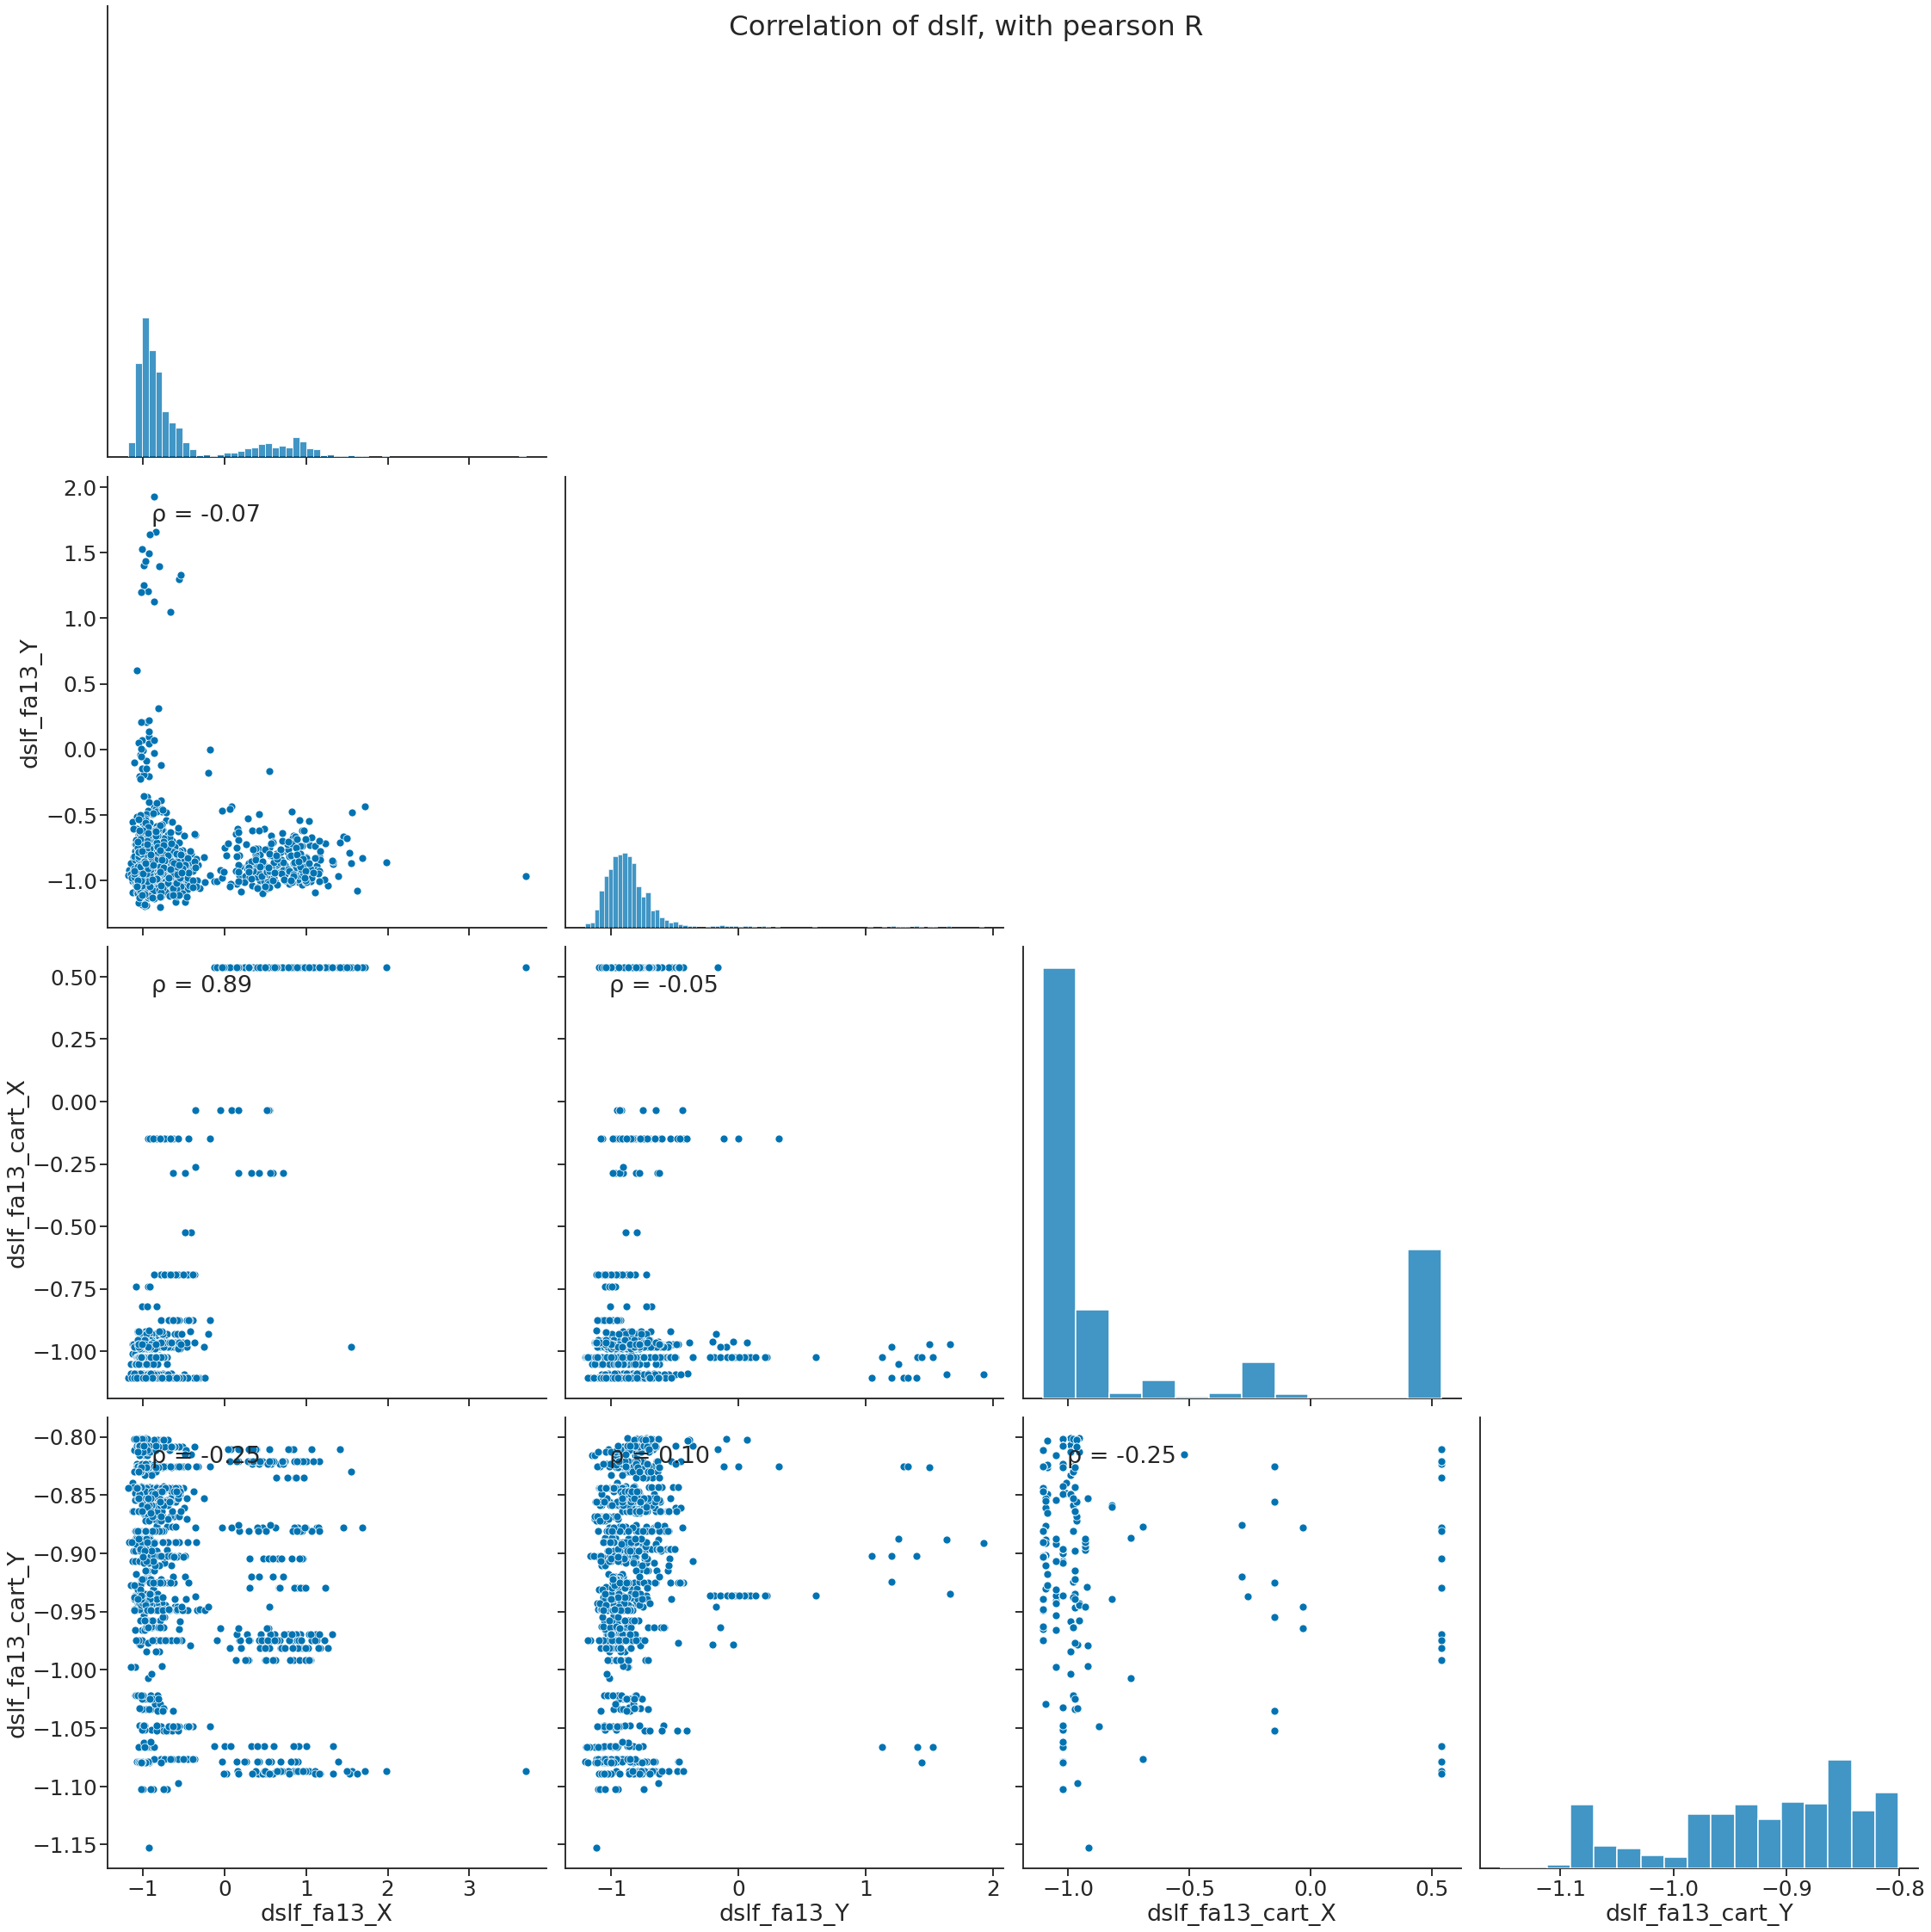

<IPython.core.display.Javascript object>

In [16]:
def rho(x, y, ax=None, **kwargs):
    """Plot the correlation coefficient in the top left hand corner of a plot.
    https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot-using-seaborn-in-python/50835066
    """
    import scipy

    r, _ = scipy.stats.pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1"
    ax.annotate(f"{rho} = {r:.2f}", xy=(0.1, 0.9), xycoords=ax.transAxes)
    
dslf_subset = scores_df[
    [
        "dslf_fa13_X",
        "dslf_fa13_Y",
        "dslf_fa13_cart_X",
        "dslf_fa13_cart_Y",
        "parent",
    ]
]

# ax = sns.pairplot(
#     data=dslf_subset.sample(frac=0.1), hue="parent", corner=True, height=8
# )
# plt.suptitle("Correlation of dslf, split by parent")
# sns.despine()
# plt.savefig("figs/06_correlations_dlsf_split_by_parent.png")

# plt.close()

ax = sns.pairplot(data=dslf_subset.sample(frac=0.1), corner=True, height=8)
ax.map_lower(rho)
plt.suptitle("Correlation of dslf, with pearson R")
sns.despine()
plt.savefig("figs/06_correlations_dlsf_pearson.png")

In [17]:
scores_df["state"] = (
    scores_df["parent"].astype(str)
    + "_p_"
    + scores_df["pivot_helix"].astype(int).astype(str)
    + "_s_"
    + scores_df["shift"].astype(int).astype(str)
)

<IPython.core.display.Javascript object>

### Get the best disulfides

In [37]:
best = scores_df[scores_df["dslf_fa13_X"] < -1]
best = best[best["dslf_fa13_Y"] < -1]
best = best[best["rmsd_final_X"] < 0.5]
best = best[best["rmsd_final_Y"] < 0.5]

idces = list(best.index)

print(len(set(best.state.values)))
print(len(best))
set(scores_df.parent.values) - set(best.parent.values)

29
366


{'DHR03_nocys',
 'DHR15_nocys',
 'DHR18_nocys',
 'DHR39',
 'DHR46',
 'DHR57',
 'DHR76',
 'DHR79',
 'DHR82',
 'TH_DHR_T7',
 'hDHR14_5CWH',
 'hDHR14_5H7C',
 'hDHR53_5CWK',
 'hDHR64_5CWM',
 'hDHR71_5CWN',
 'hDHR79_5CWP',
 'hDHR9_HFuse',
 'hTH_DHR_8_NSR',
 'hTH_DHR_DN_T6'}

<IPython.core.display.Javascript object>

In [39]:
with open(os.path.join(os.getcwd(), "06_score_dslf", "best_dslf_X.list"), "w") as f:
    for i in best.index:
        print(best.loc[i]["X_nocys_path"], file=f)
with open(os.path.join(os.getcwd(), "06_score_dslf", "best_dslf_Y.list"), "w") as f:
    for i in best.index:
        print(best.loc[i]["Y_nocys_path"], file=f)

<IPython.core.display.Javascript object>

### Get ok disulfides

In [41]:
good = scores_df[scores_df["dslf_fa13_X"] < -0.9]
good = good[good["dslf_fa13_Y"] < -0.9]
good = good[good["rmsd_final_X"] < 0.5]
good = good[good["rmsd_final_Y"] < 0.5]

idces = list(good.index)

print(len(set(good.state.values)))
print(len(good))
set(scores_df.parent.values) - set(good.parent.values)

48
1778


{'DHR18_nocys',
 'DHR39',
 'DHR76',
 'DHR79',
 'DHR82',
 'hDHR14_5CWH',
 'hDHR14_5H7C',
 'hDHR53_5CWK',
 'hDHR64_5CWM',
 'hTH_DHR_DN_T6'}

<IPython.core.display.Javascript object>

In [42]:
with open(os.path.join(os.getcwd(), "06_score_dslf", "good_dslf_X.list"), "w") as f:
    for i in good.index:
        print(good.loc[i]["X_nocys_path"], file=f)
with open(os.path.join(os.getcwd(), "06_score_dslf", "good_dslf_Y.list"), "w") as f:
    for i in good.index:
        print(good.loc[i]["Y_nocys_path"], file=f)

<IPython.core.display.Javascript object>

### Unused blocks

### Get some structures to test forward folding
Flo said `"DHR82_h4_1", "DHR82_h5_-7"` were the majority of the ones that had two modes

In [13]:
states_82 = []

for des in one_trp[one_trp["parent"] == "DHR82"].index:
    if one_trp.loc[des].state in ["DHR82_p_4_s_1", "DHR82_p_5_s_-7"]:
        states_82.append(des)


destination = os.path.join(os.getcwd(), "06_ff/test_82")
os.makedirs(destination, exist_ok=True)
for state in tqdm(states_82):
    shutil.copy(one_trp.loc[state].X_nocys_path, destination)
    shutil.copy(one_trp.loc[state].Y_nocys_path, destination)

100%|██████████| 65/65 [00:00<00:00, 88.07it/s]


<IPython.core.display.Javascript object>

In [ ]:
def basename_noext(abspath):
    basename = abspath.split("/")[-1]
    no_ext = basename.split(".")[0]
    return no_ext

for des in one_trp[one_trp["parent"] == "DHR82"].index:
    i += 1
    print(f"# {one_trp.loc[des].state}")
    print(f"load {one_trp.loc[des].X_nocys_path}")
    print(f"load {one_trp.loc[des].Y_nocys_path}")
    print(
        f"super {basename_noext(one_trp.loc[des].X_nocys_path)} and resi 1-10, {basename_noext(one_trp.loc[des].Y_nocys_path)} and resi 1-10"
    )
    print()
    
print(i)

In [ ]:
import pyrosetta
pyrosetta.distributed.init()
import pyrosetta.distributed.io as io
from pyrosetta.distributed import cluster

final_pdbs = glob(os.path.join(os.getcwd(), "06_states/*XY.pdb"))
to_inspect = []
with open("final_to_inspect.list", "w+") as f:
    for pdb in final_pdbs:
        basename_no_ext = pdb.split("_XY")[0]
        decoys = list(no_explode.index)
        for decoy in decoys:
            decoy_basename = cluster.get_scores_dict(decoy)["instance"]["tasks"]["-s"].split("/")[-1].replace(".pdb", "")
            if decoy_basename in basename_no_ext:
                decoys.remove(decoy)
                print(pdb.replace("X", "", 1), file=f)

In [ ]:
os.makedirs("06_to_order", exist_ok=True)
tag = "GHHHHHHGS"
all_id = {}
with open("final_to_inspect.list", "r") as f:
    with open("06_to_order/all.fasta", "w+") as out:
        for i, line in enumerate(f):
            all_id[f"pf_{i}"] = f"{line.rstrip()}"
            print(f">pf_{i}", file=out)
            print(tag+io.pose_from_file(line.rstrip()).pose.sequence(), file=out)
all_id

In [ ]:
import json
with open("06_to_order/all_ids.json", "w+") as f:
    print(json.dumps(all_id), file=f)

In [ ]:
test = json.loads("06_to_order/all_ids.json")
test


In [ ]:
from pyrosetta.distributed import cluster
with open("final_to_inspect.list", "r") as f:
    for line in f:
        cluster.get_scores_dict(line.rstrip()) #["instance"]["tasks"]["-s"].split("/")[-1].replace(".pdb", "")

In [ ]:
t.scores

In [ ]:
%%time
import pyrosetta
from pyrosetta.distributed import cluster
import pyrosetta.distributed.io as io

flags = """
-out:level 300
-precompute_ig 1
-detect_disulf false
-corrections::beta_nov16 true
-holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc
-indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5
"""
pyrosetta.distributed.init(" ".join(flags.replace("\n\t", " ").split()))
t = almost_linkres(
    None,
    **{
        "-s": "/mnt/home/pleung/projects/bistable_bundle/r4/hinges/05_msd_runs_1/10/0009d2892b7dbae457c1c6f8bc40fe5524115bd1423ebeb4.pdb",
        "out_path": "test",
    }
)

In [13]:
%%time
import pyrosetta
from pyrosetta.distributed import cluster
import pyrosetta.distributed.io as io

flags = """
-corrections::beta_nov16 true
"""
pyrosetta.distributed.init(" ".join(flags.replace("\n\t", " ").split()))
t = score_dslf(
    None,
    **{
        "-s": "/mnt/home/pleung/projects/bistable_bundle/r4/hinges/06_cleanup/decoys/0000/2021.06.26.14.24.46.542335_1c3348aaff704bdaa73c6d67fa2db82a.pdb.bz2",
    }
)

core.chemical.AtomICoor: {0} [ WARNING ] IcoorAtomID::atom_id(): Cannot get atom_id for POLYMER_LOWER of residue LEU 1.  Returning BOGUS ID instead.
core.conformation.Residue: {0} [ WARNING ] missing an atom: 1  H   that depends on a nonexistent polymer connection!
core.conformation.Residue: {0} [ WARNING ]  --> generating it using idealized coordinates.
core.chemical.AtomICoor: {0} [ WARNING ] IcoorAtomID::atom_id(): Cannot get atom_id for POLYMER_LOWER of residue LEU 1.  Returning BOGUS ID instead.
core.conformation.Residue: {0} [ WARNING ] missing an atom: 1  H   that depends on a nonexistent polymer connection!
core.conformation.Residue: {0} [ WARNING ]  --> generating it using idealized coordinates.
core.chemical.AtomICoor: {0} [ WARNING ] IcoorAtomID::atom_id(): Cannot get atom_id for POLYMER_LOWER of residue LEU 1.  Returning BOGUS ID instead.
core.conformation.Residue: {0} [ WARNING ] missing an atom: 1  H   that depends on a nonexistent polymer connection!
core.conformation.Re

<IPython.core.display.Javascript object>